In [1]:
from functools import partial
from math import sqrt
from pathlib import Path
import geopandas as gpd
import h3pandas
from itertools import product
import time
import timeit
import csv

In [2]:
input_dir = Path('vector_1000')
output_dir = Path.cwd()

# Get a list of all GPKG files in the folder
v_files = list(sorted(input_dir.glob('*.gpkg')))

In [3]:
# Specify the number of files to open
num_files_to_open = 5  #Layers to join
h3_res=14   #Setting h3 resolution
bench_runs=30  #Benchmark runs, should probably do 30 

In [4]:
# Loop through each GPKG file, index and join
for i, file in enumerate(v_files[:num_files_to_open]):
        col_name = file.stem.split('_')[1]  # Extracting the column name from the file name
        df = gpd.read_file(file).to_crs(4326)
        df = df.h3.polyfill(h3_res, explode=True).drop(columns=['geometry'])
        df.columns = [col_name, *df.columns[1:]]  # Setting the column to the file
        df = df.set_index('h3_polyfill')
        if i == 0:
            combined_df = df.copy()
        else:
            combined_df = combined_df.join(df)

Benchmarking for joining

In [5]:
indexing_time= []
joining_time = []

def run_loop(num_files_to_open, v_files, h3_res):
    index_time= []
    join_time= []

    start_time = time.time()
    for i, file in enumerate(v_files[:num_files_to_open]):
        
        col_name = file.stem.split('_')[1]  # Extracting the column name from the file name
        df = gpd.read_file(file).to_crs(4326)

        #Indexing benchmark
        index_Stime=time.time()
        df = df.h3.polyfill(h3_res, explode=True).drop(columns=['geometry'])
        index_Etime=time.time()
        index_Ftime = index_Etime - index_Stime
        index_time.append(index_Ftime)

        #Joining benchmark
        join_Stime=time.time()
        df.columns = [col_name, *df.columns[1:]]  # Setting the column to the file
        df = df.set_index('h3_polyfill')
        if i == 0:
            combined_df = df.copy()
        else:
            combined_df = combined_df.join(df)
        join_Etime=time.time()
        join_Ftime = join_Etime - join_Stime
        join_time.append(join_Ftime)

    # Calculate and print the time taken for each run
    end_time = time.time()
    time_taken = end_time - start_time
    
    indexing_time.append(sum(index_time))
    joining_time.append(sum(join_time))
    print(f'Run: index time - {sum(index_time)} , joining time - {sum(join_time)} seconds, Total time- {time_taken} seconds')

In [6]:
timeit.timeit(lambda: run_loop(num_files_to_open, v_files, h3_res), number=bench_runs) #Benchmark run for joining

Run: index time - 1.2729337215423584 , joining time - 0.19583487510681152 seconds, Total time- 1.530299186706543 seconds
Run: index time - 1.2957854270935059 , joining time - 0.2060379981994629 seconds, Total time- 1.564988136291504 seconds
Run: index time - 1.4009621143341064 , joining time - 0.22077131271362305 seconds, Total time- 1.705867052078247 seconds
Run: index time - 1.3428280353546143 , joining time - 0.21068668365478516 seconds, Total time- 1.6325995922088623 seconds
Run: index time - 1.446458339691162 , joining time - 0.2079331874847412 seconds, Total time- 1.7493042945861816 seconds
Run: index time - 1.3764703273773193 , joining time - 0.22606468200683594 seconds, Total time- 1.6715328693389893 seconds
Run: index time - 1.4018795490264893 , joining time - 0.20673322677612305 seconds, Total time- 1.6834659576416016 seconds
Run: index time - 1.3561086654663086 , joining time - 0.22473716735839844 seconds, Total time- 1.6592848300933838 seconds
Run: index time - 1.4142301082

50.64926960004959

Defining classes

In [7]:
def is_prime(n):
    count = 0
    if n > 1:
        for i in range(1, n + 1):
            if n % i == 0:
                count += 1
    return count == 2

def is_polygonal(s, x):
    assert s > 2 and s % 1 == 0 and x % 1 == 0
    n = (sqrt(8 * (s - 2) * x + (s - 4) ** 2) + (s - 4)) / (2 * (s - 2))
    return n % 1 == 0

def is_fibonacci(n):
    a, b = 0,1
    while a < n:
        a, b = b, a + b
    return a == n

def is_perfect(n):
    sum = 1
    i = 2
    while i * i <= n:
        if n % i == 0:
            sum = sum + i + n/i
        i += 1
    return sum == n and n != 1

In [8]:
combined_df['sum'] = combined_df.select_dtypes(include='number').sum(axis=1)
classes = [
    ('is_prime', is_prime),
    ('is_triangular', partial(is_polygonal, 3)),
    ('is_rectangular', partial(is_polygonal, 4)),
    ('is_pentagonal', partial(is_polygonal, 5)),
    ('is_hexagonal', partial(is_polygonal, 6)),
    ('is_fibonacci', is_fibonacci),
    ('is_perfect', is_perfect),
]
for i, func in enumerate(classes):
    combined_df[func[0]] = combined_df['sum'].apply(func[1])

In [9]:
numerics = list(combined_df.select_dtypes(include='number'))
combined_df = combined_df.drop(columns=numerics)

In [10]:
combinations = list(product([True, False], repeat=7))
class_mapping = {tuple(row): f'Class_{i+1:03}' for i, row in enumerate(combinations)}

Benchmarking Classification

In [11]:
classify_time=[]
def classify_loop():
    
    start_time = time.time()

    bench_class = combined_df.apply(lambda row: class_mapping[tuple(row.astype(int))], axis=1) #This should remain the same, as cell count remains static   

    end_time = time.time()
    
    # Calculate and print the time taken for each run
    time_taken = end_time - start_time
    classify_time.append(time_taken)
    print(f'Run: Time taken - {time_taken} seconds')

In [12]:
timeit.timeit(lambda: classify_loop(), number=bench_runs) #Benchmark run for classifying

Run: Time taken - 5.718534231185913 seconds
Run: Time taken - 5.806447744369507 seconds
Run: Time taken - 5.825868368148804 seconds
Run: Time taken - 5.770756959915161 seconds
Run: Time taken - 5.902108430862427 seconds
Run: Time taken - 5.942258834838867 seconds
Run: Time taken - 5.760552167892456 seconds
Run: Time taken - 5.8908610343933105 seconds
Run: Time taken - 5.849545478820801 seconds
Run: Time taken - 5.909240007400513 seconds
Run: Time taken - 5.85964822769165 seconds
Run: Time taken - 5.622684478759766 seconds
Run: Time taken - 5.826650381088257 seconds
Run: Time taken - 5.8032097816467285 seconds
Run: Time taken - 6.0096893310546875 seconds
Run: Time taken - 5.86868953704834 seconds
Run: Time taken - 5.758673906326294 seconds
Run: Time taken - 5.846710920333862 seconds
Run: Time taken - 5.769681453704834 seconds
Run: Time taken - 6.429086685180664 seconds
Run: Time taken - 5.8360466957092285 seconds
Run: Time taken - 5.973306655883789 seconds
Run: Time taken - 5.8097877502

175.525024499977

Writing benchmark results

In [13]:
with open(f'DGGS_benchmark_{num_files_to_open}_layers.csv', 'w', newline='') as csvfile: #Writing benchmark results
    writer = csv.writer(csvfile)
    writer.writerow(['Run', 'Indexing(s)', 'Joining(s)','Classify(s)'])
    for i, (index_taken, join_taken, classify_taken) in enumerate(zip(indexing_time,joining_time, classify_time)):
        writer.writerow([i+1, index_taken, join_taken, classify_taken])

Applying classification

In [14]:
combined_df['class'] = combined_df.apply(lambda row: class_mapping[tuple(row.astype(int))], axis=1) #This should remain the same, as cell count remains static

In [15]:
h3_df=combined_df[['class']]

In [16]:
h3_df=h3_df.h3.h3_to_geo_boundary() #NOT going to benchmark these yet. But this should remain the same, as cell count remains static this whole cell should take roughly 10s

In [17]:
h3_df=h3_df.dissolve(by='class').reset_index().to_crs(2193)  #Technically this is traditional method, do we even include this? I think not.

Writing Geopackage output

In [18]:
output_dir.mkdir(parents=True, exist_ok=True)
output = (output_dir / f'DGGS_{num_files_to_open}_layers.gpkg')
# output.touch(exist_ok=True)
h3_df.to_file(output, layer='benchmarking', driver='GPKG', mode='w')

<Axes: >

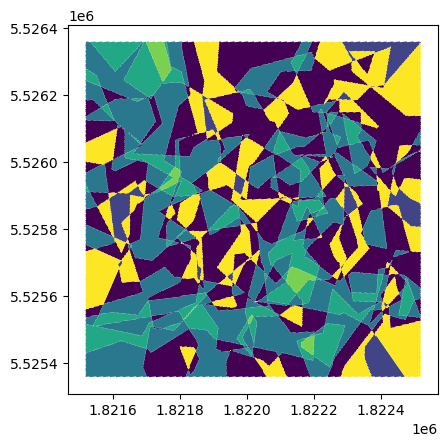

In [19]:
h3_df.plot('class', cmap='viridis')